Size of DataFrame: 287325


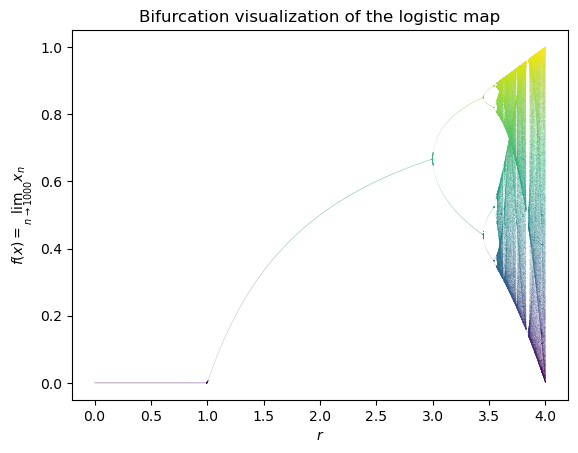

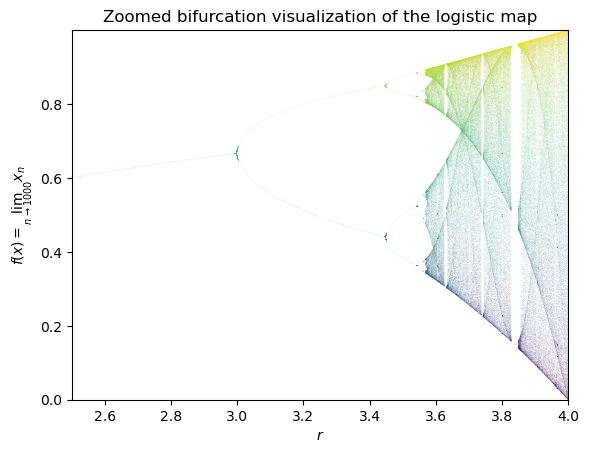

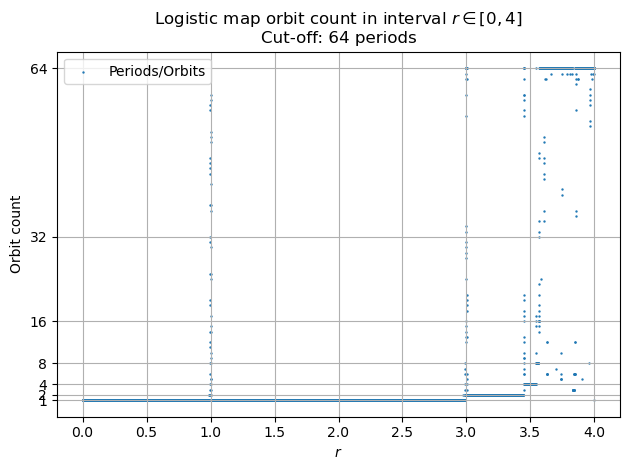

Bifurcations: [0, 3, 3.451186279656991, 3.5440886022150555, 3.5644891122278057, 3.5686892172304305, 3.5695892397309934]
Lengths: [3, 0.4511862796569912, 0.0929023225580643, 0.020400510012750228, 0.004200105002624799, 0.0009000225005628693]
Feigenbaum: [6.649138360946421, 4.856566200215265, 4.553921568627488, 4.8571428571431445, 4.666666666664528]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Functions definitions

def logistic_map(r, x):
    return r * x * (1 - x)

def cubic_map(r, x):
    return r * x - x ** 3

def iterate_map(r, x, map_func, N):
    """Perform N iterations of the given map function."""
    for _ in range(N):
        x = map_func(r, x)
    return x

def createData(r, x_init, map_func, N_warmup, N_iter):
    df = pd.DataFrame()
    x = iterate_map(r, x_init, map_func, N_warmup)
        
    # Count orbits by storing unique values in a set
    orbits = set()
    for _ in range(N_iter):
        x = map_func(r, x)
        orbits.add(np.round(x, 6))  # Floats need to be rounded to make them comparable
        
    # Save all data related to current r value
    count = len(orbits)
    orbits = np.array(list(orbits))
    df_temp = pd.DataFrame(
        {"r": np.full_like(orbits, r),
        "y": orbits,
        "orbits": np.full_like(orbits, count, dtype=int)})
    df_temp = df_temp.drop_duplicates()
    df = pd.concat([df, df_temp], ignore_index=True)
    return df

def generate_bifurcation_data(r_values, map_func, x_init=0.5, N_warmup=1000, N_iter=64) -> pd.DataFrame:
    """
    Generate bifurcation data for a range of r values and a specific map function.

    Parameters:
    r_values : array-like
        The range of r values to use.
    map_func : callable
        The map function to use.
    x_init : float, optional
        The initial x value to use. Default is 0.5.
    N_warmup : int, optional
        The number of warmup iterations to perform. Default is 1000.
    N_iter : int, optional
        The number of iterations to perform after warmup. Default is 64.

    Returns:
    DataFrame
        A DataFrame containing the r values, orbit values, and number of unique orbits.
    """
    df = pd.DataFrame()

    # Define ANSI escape codes for bold and green text
    bold_green_start = "\033[1;32m"
    bold_end = "\033[0m"


    for r in tqdm(r_values, bar_format=f'{bold_green_start}{{l_bar}}{{bar:20}}{{r_bar}}{{bar:-20b}}{bold_end}'):

        if map_func == logistic_map:
            df_temp = createData(r, x_init, map_func, N_warmup, N_iter)
            df = pd.concat([df, df_temp], ignore_index=True)
        elif map_func == cubic_map:
            for x_0 in np.linspace(-np.sqrt(1 + r), np.sqrt(1 + r), 10 + 2)[1:-1]:
                df_temp = createData(r, x_0, map_func, N_warmup, N_iter)
                df = pd.concat([df, df_temp], ignore_index=True)
    
    return df

def plot_bifurcation_data(df, figname, zoom_r_min=None, case="small"):
    """
    Plot bifurcation data and save the figure.

    Parameters:
    df : DataFrame
        The DataFrame containing the bifurcation data.
    figname : str
        The base name of the figure file.
    zoom_r_min : float, optional
        The minimum r value for a zoomed-in plot. If None, no zoomed-in plot is created.
    """
    # Normalize the y-values to the range [0, 1]
    y_norm = (df.y - df.y.min()) / (df.y.max() - df.y.min())

    # Choose a colormap
    cmap = cm.viridis
    alpha = 0.01 if case == "large" else 0.3

    # Create the plot
    plt.scatter(df.r, df.y, s=0.1, alpha=alpha, edgecolors="None", color=cmap(y_norm))
    plt.xlabel(r"$r$")
    plt.ylabel(r"$f(x) = \lim_{n\rightarrow 1000} x_n$")
    plt.title(f"Bifurcation visualization of the {MAP} map")
    plt.savefig(figname + ".png", dpi=900)
    # plt.savefig(figname + ".pdf")
    plt.show()
    plt.close()

    if zoom_r_min is not None and MAP != "logistics":
        alpha = 0.02 if case == "large" else 0.2
        
        # Create a zoomed-in plot
        df_zoom = df[df.r > zoom_r_min]

        # Normalize the y-values to the range [0, 1]
        y_norm = (df_zoom.y - df_zoom.y.min()) / (df_zoom.y.max() - df_zoom.y.min())
        
        fig, ax = plt.subplots()

        # Create the plot
        ax.scatter(df_zoom.r, df_zoom.y, s=0.1, alpha=alpha, edgecolors="None", color=cmap(y_norm))
        ax.set_xlim(df_zoom.r.min(), df_zoom.r.max())
        ax.set_ylim(df_zoom.y.min(), df_zoom.y.max())
        ax.set_xlabel(r"$r$")
        ax.set_ylabel(r"$f(x) = \lim_{n\rightarrow 1000} x_n$")
        ax.set_title(f"Zoomed bifurcation visualization of the {MAP} map")
        # plt.savefig(figname + "_zoom.pdf")
        
        # # Create an inset_axes instance with a width and height of 30% of the figure size, 
        # # and position it at the lower left corner (1, 1) of the figure
        # inset_ax = inset_axes(ax, width="50%", height="50%", loc=3)

        # # Now you can plot on the inset_axes instance like any other axes
        # inset_ax.scatter(df_zoom.r, df_zoom.y, s=0.4, alpha=0.2, edgecolors="None", color=cmap(y_norm))
        
        # # Remove ticks
        # inset_ax.set_xticklabels([])
        # inset_ax.set_yticklabels([])
        # inset_ax.set_xticks([])
        # inset_ax.set_yticks([])

        # # Set the x and y limits for the inset
        # inset_r_min, inset_r_max = 3.8289, 3.84996
        # inset_y_min, inset_y_max = 0.137, 0.16
        # inset_ax.set_xlim(inset_r_min, inset_r_max)
        # inset_ax.set_ylim(inset_y_min, inset_y_max)  # Adjust these limits to match your data
        
        # # Add vertical dashed lines pointing to the zoomed region
        # for r in [inset_r_min, inset_r_max]:
        #     ax.vlines(r, inset_y_min, inset_y_max, colors='k', linewidth=1)
        # for y in [inset_y_min, inset_y_max]:
        #     ax.hlines(y, inset_r_min, inset_r_max, colors='k', linewidth=1)

        # # Optionally, you can add grid lines to the inset
        # inset_ax.grid(True)
        
        # ax.annotate(
        #         "", xy=(inset_r_max, inset_y_min), xycoords='data',
        #         xytext=(inset_r_max, inset_y_min), textcoords=inset_ax.transData,
        #         arrowprops=dict(arrowstyle="-", linestyle="dashed", color="black")
        # )
        # ax.annotate(
        #         "", xy=(inset_r_max, inset_y_max), xycoords='data',
        #         xytext=(inset_r_max, inset_y_max), textcoords=inset_ax.transData,
        #         arrowprops=dict(arrowstyle="-", linestyle="dashed", color="black")
        #)
        
        fig.savefig(figname + "_zoom.png", dpi=900)
        # Show the plot
        plt.show()
        
        

def plot_orbit_data(df, figname):
    """
    Plot the orbit count data and save the figure.

    Parameters:
    df : DataFrame
        The DataFrame containing the orbit count data.
    figname : str
        The name of the figure file.
    """
    plt.scatter(df.r, df.orbits, s=0.5, label="Periods/Orbits")
    plt.grid(True, which='both')
    ticks = np.power(2, np.arange(0, 7))
    plt.yticks(ticks)  # Set y-ticks to powers of 2 from 2^0 to 2^6 (i.e., up to 64)
    plt.xlabel(r"$r$")
    plt.ylabel("Orbit count")
    if MAP == "logistic":   
        plt.title(r"Logistic map orbit count in interval $r \in [0, 4]$" + "\nCut-off: 64 periods")
    else:
        plt.title(r"Cubic map orbit count in interval $r \in [0, 3]$" + "\nCut-off: 64 periods")
    plt.legend()
    plt.tight_layout()
    plt.savefig(figname + ".pdf")
    plt.show()

def compute_bifurcation_lengths(bifurcations):
    """
    Compute the lengths of bifurcation intervals.

    Parameters:
    bifurcations : list
        The list of bifurcation points.

    Returns:
    list
        The list of bifurcation interval lengths.
    """
    lengths = []
    for i in range(len(bifurcations) - 1):
        lengths.append(bifurcations[i+1] - bifurcations[i])
    return lengths

def compute_feigenbaum_constants(lengths):
    """
    Compute the Feigenbaum constants.

    Parameters:
    lengths : list
        The list of bifurcation interval lengths.

    Returns:
    list
        The list of Feigenbaum constants.
    """
    feigenbaum = []
    for i in range(len(lengths) - 1):
        feigenbaum.append(lengths[i] / lengths[i+1])
    return feigenbaum

# Select which case to run
CASE = "small"      # Choose "large" or "small"
MAP = "logistic"    # Choose "logistic" or "cubic"
GENERATE = True     # Whether to generate data or read it from a file

# Set parameters based on selected case
if CASE == "large":
    r_values = np.linspace(0, 4, num=40000) if MAP == "logistic" else np.linspace(0, 3, num=30000)
    r_inset = np.linspace(3.828957239309828, 3.849962490622656, num=1000) if MAP == "logistic" else np.linspace(0, 3, num=30000)
    r_values = np.concatenate((r_values, r_inset))
else:
    r_values = np.linspace(0, 4, num=4000) if MAP == "logistic" else np.linspace(0, 3, num=3000)

# Set map function based on selected map
map_func = logistic_map if MAP == "logistic" else cubic_map

df = pd.DataFrame()
# Generate bifurcation data
if GENERATE:
    if MAP == "logistic":
        for x in np.linspace(0.01, 1, 10, False):  
            df_temp = generate_bifurcation_data(r_values, map_func, x_init=x)
            df = pd.concat([df, df_temp], ignore_index=True)

        df_temp = generate_bifurcation_data(r_values, logistic_map)
        df = pd.concat([df, df_temp], ignore_index=True)
        # Remove duplicate data points
        df = df.drop_duplicates()
    elif MAP == "cubic":
        df_temp = generate_bifurcation_data(r_values, map_func)
        df = pd.concat([df, df_temp], ignore_index=True)
        df = df.drop_duplicates()

    # Save bifurcation data to a CSV file
    df.to_csv(f'bifurcationData_{MAP}_{CASE}.csv', index=False)
else:
    df = pd.read_csv(f'bifurcationData_{MAP}_{CASE}.csv')

print(f"Size of DataFrame: {df.shape[0]}")
# Plot bifurcation data
plot_bifurcation_data(df, f"bifurcation_{MAP}_{CASE}", zoom_r_min=2.5 if MAP == "logistic" else None, case=CASE)

# Remove duplicates in r and orbits
df = df.drop_duplicates(['r', 'orbits'])

# Plot orbit data
plot_orbit_data(df, f"orbits_{MAP}_{CASE}")

# Save DataFrame to a CSV file
df.to_csv(f"orbits_{MAP}_{CASE}.csv", index=False)

# Define bifurcation points
# Add points by hand because the data has too much noise
if MAP == "logistic":
    bifurcations = [
        0,
        3,  # Transition to 2-periodic
        3.451186279656991,  # 4
        3.5440886022150555,  # 8
        3.5644891122278057,  # 16   
        3.5686892172304305,  # 32   
        3.5695892397309934  # 64
    ]
else: 
    bifurcations = [
        0,
        2.000,  # Transition to 2-periodic
        2.2362292076402546,  # 4
        2.287913697123237,  # 8
        2.2992103070102337,  # 16   
        2.301609586986233,  # 32   
        2.3021094369812327  # 64
    ]

print(f"Bifurcations: {bifurcations}")

# Compute bifurcation lengths
lengths = compute_bifurcation_lengths(bifurcations)
print(f"Lengths: {lengths}")

# Compute Feigenbaum constants
feigenbaum = compute_feigenbaum_constants(lengths)
print(f"Feigenbaum: {feigenbaum}")
